#  **Assignment 1**

**Your name: <enter 朱柏諺 Brian>**

**Registered email: brianchu1021@gmail.com**

**Class: E1**

In this homework, you will build a model for predicting house prices. For this, you will use real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Your task is to:
1. Develop a better model to reduce the prediction error. You can find some hints on the last section.
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

In [1281]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import os
import numpy as np
import torch
import pandas as pd

## Preliminary Setup

In [1282]:
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(f'{i+1} GPU: {torch.cuda.get_device_name(i)}')

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

No GPU available, using CPU.


## Get the training and test dataset from Kaggle

In [1283]:
# try:
# import google.colab
# import requests
# url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment1/master/config.py'
# r = requests.get(url, allow_redirects=True)
# open('config.py', 'wb').write(r.content)
# except ModuleNotFoundError:
#     pass
# from config_module import *
# config_data()

Download the train and test dataset from [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) (in the Data tab). You will need to sign it to access the data. These are two Comma Separated Values (CSV) files containing training and test data respectively we use Pandas.

Save them into your google drive. To read them into your code, use the following command (from panda)

In [1284]:
train_data = pd.read_csv('data/train.csv')  # change the name and the path as needed
test_data  = pd.read_csv('data/test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label. The test data contains 1,459 examples and 80 features. You can check the content of the files by opening them in Excel or by using the following two commands

In [1285]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [1286]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [1287]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.dtypes[all_features.dtypes != 'object'].index)
all_features.shape

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


(2919, 79)

Non Numeric Feature Example

In [1288]:
all_features['MSZoning']

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1454    RM
1455    RM
1456    RL
1457    RL
1458    RL
Name: MSZoning, Length: 2919, dtype: object

## **1. Accessing and Reading the Kaggle Data Sets**

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition.

The data includes multiple data types, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'.

The price of each house, namely the label, is only included in the training data set (it is a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). It is already part of colab.

## **2. Data Preprocessing**

As stated above, we have a wide variety of datatypes. Before we feed it into a  network we need to perform some amount of processing.

Let's start with the **numerical features**. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

This process is called **normalization** or **standardisation**. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

Write below the code that does the normalization for each numerical features:

## Data Balancing

In [1289]:
import smogn
# source: https://github.com/nickkunz/smogn/blob/master/examples/smogn_example_3_adv.ipynb
rg_mtrx = [

    [35000,  1, 0],  ## over-sample ("minority")
    [125000, 0, 0],  ## under-sample ("majority")
    [200000, 0, 0],  ## under-sample
    [250000, 0, 0],  ## under-sample
]
# conduct smogn
train_data = smogn.smoter(
    
    ## main arguments
    data = train_data,           ## pandas dataframe
    y = 'SalePrice',          ## string ('header name')
    k = 9,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.10,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)


dist_matrix:   7%|6         | 10/151 [00:00<00:12, 11.35it/s]

r_index: 100%|##########| 126/126 [00:01<00:00, 99.80it/s]


In [1290]:
from numpy import nan
train_data.reset_index(drop=True, inplace=True)
train_features = train_data.iloc[:, 1:-1].copy(deep=True)
train_labels   = train_data.iloc[train_features.index,-1:].copy(deep = True)
# train_features.replace('NaN', nan)
train_features.dropna(thresh=7, inplace=True) # drop rows having more than 7 missing values
# train_features.reset_index(drop = True, inplace = True)
train_labels = train_labels.iloc[train_features.index,-1:]
# remove outliers
# from sklearn.ensemble import IsolationForest
# numeric_features = train_features.dtypes[train_features.dtypes != 'object'].index
# clf = IsolationForest(max_samples = 100, random_state = 42)
# clf.fit(train_features[numeric_features])
# y_noano = clf.predict(train_features[numeric_features])
# y_noano = pd.DataFrame(y_noano, columns = ['Top'])

# train_features = train_features.iloc[y_noano[y_noano['Top'] == 1].index.values]

n_train = train_features.shape[0]
print(train_features.shape, train_labels.shape)
train_labels.reset_index(drop=True, inplace=True)
train_features.reset_index(drop=True, inplace=True)
test_features = test_data.iloc[:, 1:]
test_features = test_features[train_features.columns]
all_features = pd.concat([train_features, test_features], axis=0)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# all_features[numeric_features].fillna(0, inplace=True)

(1309, 60) (1309, 1)


In [1291]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f'Shape of all features: {all_features.shape}')
print(f'Shape of all training label: {train_labels.shape}')
# print(all_features)
# print(f'Shape of non-processed training: {train_data.shape}')
# print(f'Shape of non-processed test: {test_data.shape}')

Shape of all features: (2768, 236)
Shape of all training label: (1309, 1)


## Missing Value Handling using MICE (numeric)
(Though not using mean has a better performance lol)

In [1292]:

import miceforest as mf
numeric_features = all_features.dtypes[all_features.dtypes != 'bool'].index
# all_features.
# print(numeric_features)
for col in numeric_features:
    all_features[col] = pd.to_numeric(all_features[col])
    # all_features[col] = all_features[col].fillna(all_features[col].mean())
# for col in set(all_features.columns).difference(set(numeric_features)):
#     all_features[col] = pd.Categorical(all_features[col])

# print(all_features.shape)
# print(list(all_features.isna().sum(axis=0)))

kds = mf.ImputationKernel(
  all_features[numeric_features],
  random_state=5
)
# Run the MICE algorithm for 5 iterations
kds.mice(10)

all_features[numeric_features] = kds.complete_data()


# Set missing values to 0
# all_features = all_features.fillna(0)
all_features.shape

# Normalize the numerical features
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [1293]:
# Examine data after normalizing numeric features
# all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
# print(all_features)

Next we deal with the **discrete values**. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [1294]:
# Examine data after one hot encoding
# all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

In [1295]:
# all_features['MSZoning_RL']

You can see that this conversion increases the number of features from 79 to 331.

Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and prepare them for training.

In [1296]:
print((all_features['Street_nan'].isna().sum()))
# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# the train feature are in all_features[:n_train].values - need to convert them into a pytorch tensor??
train_features = np.array(all_features[:n_train].values).astype(np.float32)
print(train_features.shape)
# the test feature are in all_features[n_train:].values - need to convert them into a pytorch tensor??
test_features  = np.array(all_features[n_train:].values).astype(np.float32)
print(test_features.shape)
# the train labels are in train_data.SalePrice.values - need to convert them into a pytorch tensor??
train_labels   = np.array(train_labels).reshape((-1, 1)).astype(np.float32)
# print(pd.DataFrame(test_features).isna().sum().sum())
# print(pd.DataFrame(train_features).isna().sum())
# print(pd.DataFrame(train_labels).isna().sum())

0
(1309, 236)
(1459, 236)


## **3. Training**

### **3.1. Loss function**
To get started, train an MLP model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

To this end, use the codes you developed in Lab 4. However, we may need to test with a better loss function to achieve better results. In fact, house prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy between the predicted price and the correct price in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in the Kaggle competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

## RMSE Loss
Use RMSE to train the model

In [1297]:
from torch import nn

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

## MLP Model & Trainer

In [1298]:


class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  
  def __init__(self, inputSize=32 * 32 * 3, outputSize=10, lr=0.01, weight_decay = 0):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputSize, 128),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.Dropout(0.2),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(32, 16),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(16, 8),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(8, outputSize),
    )
    # Setting the learning rate
    self.lr = lr
    self.weight_decay = weight_decay

  ## The forward step
  def forward(self, X):
    # Computes the output given the input X
    return self.layers(X)

  ## The loss function - Here, we will use MSLE
  def loss(self, y_hat, y):
    fn = RMSLELoss()
    return fn(y_hat, y)

  ## The optimization algorithm
  #  Let's this time use Adam, which is the most commonly used optimizer in neural networks
  def configure_optimizers(self):
    # return torch.optim.SGD(self.parameters(), self.lr)
    return torch.optim.Adam(self.parameters(), self.lr, weight_decay=self.weight_decay)

class Trainer:
    def __init__(self, n_epochs=3):
        self.max_epochs = n_epochs
        self.train_losses = []  # 保存每個 epoch 的訓練損失
        return

    def fit(self, model, trainloader, validloader=None):
        self.optimizer = model.configure_optimizers()
        self.model = model

        for epoch in range(self.max_epochs):
            self.fit_epoch(trainloader)

            # 計算並保存訓練損失
            avg_train_loss = sum(self.train_losses[-len(trainloader):]) / len(trainloader)
            print(f'Epoch {epoch + 1}/{self.max_epochs}, Average Training Loss: {avg_train_loss:.4f}')

            if validloader is not None:
                # 如果有提供 validation DataLoader，則進行 validation 評估
                valid_rmsle = self.evaluate_rmsle(model, validloader)
                print(f'Validation RMSLE: {valid_rmsle:.4f}')

        print("Training process has finished")

    def fit_epoch(self, trainloader):
        self.model.train()
        current_loss = 0.0

        for i, data in enumerate(trainloader):
            inputs, target = data
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.model.loss(outputs, target)
            loss.backward()
            self.optimizer.step()

            current_loss += loss.item()

            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
                current_loss = 0.0

        # 保存本 epoch 的訓練損失
        self.train_losses.append(current_loss)

    def evaluate_rmsle(self, model, dataloader):
        model.eval()
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                outputs = model(inputs)
                loss = model.loss(outputs, targets)
                total_loss += loss.item()
                total_samples += len(targets)

        rmsle = torch.sqrt(torch.tensor(total_loss / total_samples))
        return rmsle.item()

## Dataset

In [1299]:
from torch.utils.data import Dataset
class HousePriceDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        if(type(x_tensor) == np.ndarray):
            self.x = x_tensor
            self.y = y_tensor
        else:
            self.x = x_tensor.values
            self.y = y_tensor.values
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

### **3.2. k-Fold Cross-Validation**

To get good performance, you usually need to select the network architecture. This includes the type of network, the number of layers, the number of hidden neurons in each layer, the learning rate, the batch size, etc. These are called **hyper paramters**.

However, it is difficult to know which configuration of the hyperparameters above would achieve the best performance. Thus in practice, we need to try multiple configurations (i.e., choices of the hyperparameters), evaluate the performance of each configuration, and pick the one that gives the best performance.

To assess the performance of a given configuratation, you need to take the training set and randomly divide it into two subsets:
- one subset will be called training set (usually 80% of the entire data set),
- the second one will be called validation set (usually 20% of the entire data set.

Then, train your model on the training set and test it on the validation set. Repeat this process $k$ times and average the performance over all the run. This will then be the performance of this configuration. This process is called **$k-$fold cross validation**. $k$ is usually chosen to be $5$ or $10$.

Run this procedure for each of the configurations you defined and pick the one that gives the best performance.

To use it, first we need a function that returns the i-th fold of the data in a k-fold cross-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data.

Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [1300]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    # print("fold size ", fold_size)
    X_train, y_train = None, None

    for j in range(k):
        # print(f'{j} of {k}')
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # print("slice: ", idx)
        X_part, y_part = X[idx], y[idx]
        # print(X_part)
        # print(y_part)
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_part)], ignore_index=True)
            y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_part)], ignore_index=True)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [1301]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):

    train_sum, valid_sum = 0, 0

    for i in range(k):

        data = get_k_fold_data(k, i, X_train, y_train)
        print(data[0].shape, data[1].shape)
        net = MLP(inputSize=data[0].shape[1], outputSize=1, lr=learning_rate, weight_decay=weight_decay)
        trainer = Trainer(n_epochs=num_epochs)
        trainloader = torch.utils.data.DataLoader(HousePriceDataset(data[0], data[1]), batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(HousePriceDataset(data[2], data[3]), batch_size=batch_size, shuffle=False)

        trainer.fit(net, trainloader, validloader)

        # 在每個 fold 完成後，根據 trainer 中保存的 train_losses 計算 train 和 validation 的 RMSLE
        avg_train_rmsle = trainer.evaluate_rmsle(net, trainloader)
        avg_valid_rmsle = trainer.evaluate_rmsle(net, validloader)

        train_sum += avg_train_rmsle
        valid_sum += avg_valid_rmsle

        print('fold %d, train rmsle: %f, valid rmsle: %f' % (
            i, avg_train_rmsle, avg_valid_rmsle))

    return train_sum / k, valid_sum / k

Finding a good choice of the hyperparameters can take quite some time, depending on how many things one wants to optimize over. Within reason the $k$-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

In [1302]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.0025, 0, 360
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

(1044, 236) (1044, 1)
Epoch 1/300, Average Training Loss: 11.4874
Validation RMSLE: 0.2124
Epoch 2/300, Average Training Loss: 22.9272
Validation RMSLE: 0.2120
Epoch 3/300, Average Training Loss: 34.2927
Validation RMSLE: 0.2110
Epoch 4/300, Average Training Loss: 33.9843
Validation RMSLE: 0.2086
Epoch 5/300, Average Training Loss: 33.3431
Validation RMSLE: 0.2043
Epoch 6/300, Average Training Loss: 32.2130
Validation RMSLE: 0.1982
Epoch 7/300, Average Training Loss: 30.5628
Validation RMSLE: 0.1910
Epoch 8/300, Average Training Loss: 28.5544
Validation RMSLE: 0.1836
Epoch 9/300, Average Training Loss: 26.4037
Validation RMSLE: 0.1764
Epoch 10/300, Average Training Loss: 24.3165
Validation RMSLE: 0.1696
Epoch 11/300, Average Training Loss: 22.3711
Validation RMSLE: 0.1632
Epoch 12/300, Average Training Loss: 20.6046
Validation RMSLE: 0.1573
Epoch 13/300, Average Training Loss: 18.9971
Validation RMSLE: 0.1518
Epoch 14/300, Average Training Loss: 17.5873
Validation RMSLE: 0.1467
Epoch 1

Validation RMSLE: 0.1064
Epoch 25/300, Average Training Loss: 7.9657
Validation RMSLE: 0.1030
Epoch 26/300, Average Training Loss: 7.4158
Validation RMSLE: 0.0997
Epoch 27/300, Average Training Loss: 6.8846
Validation RMSLE: 0.0964
Epoch 28/300, Average Training Loss: 6.3728
Validation RMSLE: 0.0931
Epoch 29/300, Average Training Loss: 5.8864
Validation RMSLE: 0.0899
Epoch 30/300, Average Training Loss: 5.4467
Validation RMSLE: 0.0867
Epoch 31/300, Average Training Loss: 5.0313
Validation RMSLE: 0.0835
Epoch 32/300, Average Training Loss: 4.6228
Validation RMSLE: 0.0804
Epoch 33/300, Average Training Loss: 4.2371
Validation RMSLE: 0.0773
Epoch 34/300, Average Training Loss: 3.8632
Validation RMSLE: 0.0743
Epoch 35/300, Average Training Loss: 3.5223
Validation RMSLE: 0.0713
Epoch 36/300, Average Training Loss: 3.1975
Validation RMSLE: 0.0683
Epoch 37/300, Average Training Loss: 2.9162
Validation RMSLE: 0.0654
Epoch 38/300, Average Training Loss: 2.6423
Validation RMSLE: 0.0626
Epoch 39/

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $k$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.


##  **4. Predict and Submit**

Once you have figured out what a good choice of hyperparameters should be, you might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

So your task here is that once you have decided what are the best hyperparameters, train on the entire Kaggle training set, test it on the Kaggle test set, save the result as a .csv file and submit it to Kaggle. The steps are quite simple:
* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

You need to include a screenshot of your results in the assignment submission.

## Prediction

In [1303]:
class HousePriceTestDataset(Dataset):
    def __init__(self, x_tensor):
        if(type(x_tensor) == np.ndarray):
            self.x = x_tensor
        else:
            self.x = x_tensor.values
        
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

test_dataset = HousePriceTestDataset(test_features)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

net = MLP(inputSize=test_features.shape[1], outputSize=1, lr=lr, weight_decay=weight_decay)
trainer = Trainer(n_epochs=num_epochs)
trainloader = torch.utils.data.DataLoader(HousePriceDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
trainer.fit(net, trainloader)
net.eval()
predictions = []

with torch.no_grad():
    for inputs in testloader:
        outputs = net(inputs)
        predictions.extend(outputs.numpy().reshape(-1))

Epoch 1/300, Average Training Loss: 11.6494
Epoch 2/300, Average Training Loss: 23.2180
Epoch 3/300, Average Training Loss: 34.6319
Epoch 4/300, Average Training Loss: 45.7534
Epoch 5/300, Average Training Loss: 44.7251
Epoch 6/300, Average Training Loss: 43.0382
Epoch 7/300, Average Training Loss: 40.6835
Epoch 8/300, Average Training Loss: 37.7568
Epoch 9/300, Average Training Loss: 34.5301
Epoch 10/300, Average Training Loss: 31.3882
Epoch 11/300, Average Training Loss: 28.4578
Epoch 12/300, Average Training Loss: 25.8474
Epoch 13/300, Average Training Loss: 23.5930
Epoch 14/300, Average Training Loss: 21.5632
Epoch 15/300, Average Training Loss: 19.7764
Epoch 16/300, Average Training Loss: 18.1824
Epoch 17/300, Average Training Loss: 16.7054
Epoch 18/300, Average Training Loss: 15.3770
Epoch 19/300, Average Training Loss: 14.1348
Epoch 20/300, Average Training Loss: 13.0009
Epoch 21/300, Average Training Loss: 11.9613
Epoch 22/300, Average Training Loss: 10.9651
Epoch 23/300, Avera

In [1304]:
for i, pred in enumerate(predictions):
    print(f"Prediction for example {i + 1}: {float(pred)}")

# Or if you want to save the predictions to a file, for example, a CSV file
import pandas as pd

# Assuming 'predictions' and 'X_test' are both lists or arrays

output_df = pd.DataFrame({'Id':[x for x in range(1461, 2920)], 'SalePrice': predictions})
output_df.to_csv('predictions.csv', index=False)

Prediction for example 1: 118094.5234375
Prediction for example 2: 117956.671875
Prediction for example 3: 177952.71875
Prediction for example 4: 199377.40625
Prediction for example 5: 202254.5
Prediction for example 6: 173401.71875
Prediction for example 7: 181612.84375
Prediction for example 8: 161796.0
Prediction for example 9: 184800.625
Prediction for example 10: 122129.28125
Prediction for example 11: 190846.609375
Prediction for example 12: 96144.9296875
Prediction for example 13: 94633.703125
Prediction for example 14: 146038.734375
Prediction for example 15: 108684.875
Prediction for example 16: 332216.96875
Prediction for example 17: 251030.640625
Prediction for example 18: 276004.34375
Prediction for example 19: 281700.875
Prediction for example 20: 398302.1875
Prediction for example 21: 293191.28125
Prediction for example 22: 207887.75
Prediction for example 23: 179827.3125
Prediction for example 24: 156810.8125
Prediction for example 25: 187469.0625
Prediction for example 

## **5. What you need to do in this assignment**

In this assignment, you need to come up with the best neural network that can predict the house prices. This includes:
- The choice of the network: convolutional network, MLP, a combination, ...
- Setting the hyperparameters including the number of layers and the number of neurons in each layer.
- Train it on the Kaggle train set and test it on the Kaggle test set.

You may want to consider the following **hints**:
1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold cross validation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?

**5。您在此作業中需要做什麼**

在這項任務中，您需要建立一個能夠預測房價的最佳神經網路。這包括
- 選擇網路：卷積網路、MLP、組合網路...
- 設定超參數，包括層數和每層的神經元數。
- 在 Kaggle 訓練集上進行訓練，並在 Kaggle 測試集上進行測試。

您可能需要考慮以下提示：
1. 能否透過直接最小化對數價格來改進模型？如果嘗試預測價格對數而不是價格，會發生什麼情況？
1. 用平均值替換缺失值是否總是個好主意？提示--你能建立一種數值不是隨機缺失的情況嗎？
1. 找到更好的表示方法來處理缺失值。提示--如果新增一個指標變數會怎樣？
1. 透過 k 倍交叉驗證調整超參數，提高在 Kaggle 上的得分。
1. 透過改進模型（層、正規化、剔除）來提高得分。
1. 如果我們不對連續數值特徵進行標準化處理，會發生什麼情況？

**What to submit**
- The colab notebook that implements the solution. You can update directly this notebook, as as many sections as you want. When I run your notebook, it  should load the Kaggle data. Make sure you provide enough explanation of your work.
- A screenshot of your score on Kaggle.

**需要提交什麼**
- 實作該解決方案的 Colab 筆記本。
- 您可以直接更新此筆記本，可以更新任多個部分。
- 當我運行你的筆記本時，它應該加載 Kaggle 資料。確保你對你的工作提供了足夠的解釋。
- 您在 Kaggle 上的得分的螢幕截圖。

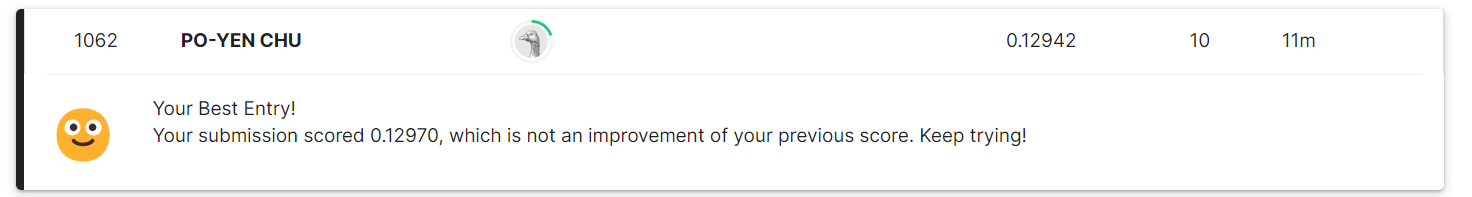